# Initialization

In [1]:
parallel = True
%run utils.ipynb

In [2]:
# unit: um
field_min_x = 0
field_max_x = 226.3
field_min_y = 0
field_max_y = 132.22

In [3]:
if parallel:
    import ipyparallel as ipp
    rc = ipp.Client()
    dview = rc[:]
    dview.push(dict(get_intersection=get_intersection))
    
    @dview.parallel(block=True)
    def get_nearest_intersections_parallel(points, all_lines, all_intersections, show=False):
        print('*** get_nearest_intersections() ***')
        nearest_intersections = []

        for point_id, intersections in enumerate(all_intersections):
            if show:
                print('*** Point id:', point_id)
            else:
                print('\rPoint id: {} / {}'.format(point_id+1, len(points)), end='')

            p = points[point_id]
            nearest_intersections_tmp = []

            for intxn in intersections:
                if show: print('    Intxn:', intxn)
                line_to_intxn = {'a': intxn['y'] - p[1],
                                 'b': p[0] - intxn['x'],
                                 'c': (intxn['x'] - p[0]) * p[1] - (intxn['y'] - p[1]) * p[0]}

                lines = [l for l in all_lines[point_id] if not l['id'] in intxn['id']]

                add_to_list = True

                for line in lines:
                    if show: print('        Line:', line)
                    intxn_new = get_intersection(line, line_to_intxn)
                    if show: print('          intxn_new:', intxn_new, end='')

                    if intxn_new:
                        min_x = min(p[0], intxn['x'])
                        max_x = max(p[0], intxn['x'])
                        min_y = min(p[1], intxn['y'])
                        max_y = max(p[1], intxn['y'])

                        if min_x <= intxn_new['x'] <= max_x and min_y <= intxn_new['y'] <= max_y:
                            if intxn_new['y'] == intxn['y'] and intxn_new['x'] == intxn['x']:
                                if show: print(' On the line')
                            else:
                                if show: print(' NG')
                                add_to_list = False
                        else:
                            if show: print('')
                    else:
                        if show: print('')

                if add_to_list:
                    existing_intxn_list = [[a['x'], a['y']] for a in nearest_intersections_tmp]
                    if [intxn['x'], intxn['y']] in existing_intxn_list:
                        if show: print('        -> NG (Already exists)', end='\n\n')
                    else:
                        if show: print('        -> OK', end='\n\n')
                        nearest_intersections_tmp.append(intxn)
                else:
                    if show: print('        -> NG (Not nearest)', end='\n\n')

            nearest_intersections.append(nearest_intersections_tmp)
            if show: pprint.pprint(nearest_intersections_tmp)
            if show: print('')

        return nearest_intersections

# Points for test

In [4]:
points0 = [[1,5],
           [2,2],
           [2,8],
           [4,8],
           [5,1],
           [6,6],
           [10,4],
           [10,6],
           [10,8],
           [12,9],
           [12,1],
           [14,6]]

points1 = [[2,8],
          [10,8],
          [6,6]]

points2 = [[2,8],
          [10,8],
          [6,2],
          [6,4],
          [6,6]]

points3 = [[4,3],[4,6],[4,9],
           [8,3],[8,6],[8,9],
           [12,3],[12,6],[12,9]]

points4 = [[1,1],
          [1,4],
          [4,1],
          [4,4],
          [2,2],
          [3,2]]

In [5]:
import random
rnd_x = sorted([random.random() * 15 for i in range(50)])
rnd_y = [random.random() * 10 for i in range(50)]
points5 = [[x, y] for x, y in zip(rnd_x, rnd_y)]

# Load CSV

In [6]:
df_coordinates = pd.read_csv('../../Second_section_Jones_PAS/200126test/200126coordinates.csv')
points = [[row.at['X(um)'], row.at['Y(um)']] for i, row in df_coordinates.iterrows()]

# Calculation

In [7]:
#points = points5
all_lines = points_to_lines(points)
all_intersections = lines_to_intersections(all_lines)

In [8]:
if parallel:
    nearest_intersections = get_nearest_intersections_parallel(points,
                                                               all_lines,
                                                               all_intersections)
else:
    nearest_intersections = get_nearest_intersections(points,
                                                      all_lines,
                                                      all_intersections,
                                                      show=False)

In [9]:
segments = get_line_segments(nearest_intersections, show=False)

# Results

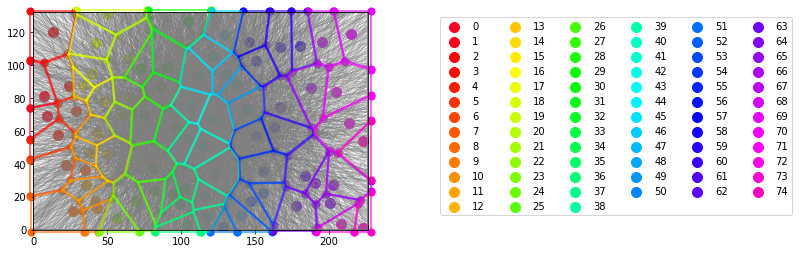

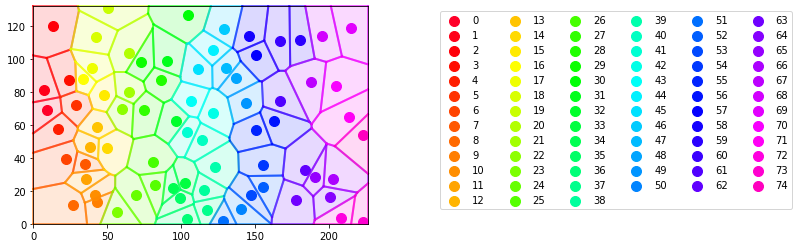

In [10]:
plot(points, all_lines, nearest_intersections, segments)
plot(points, all_lines, nearest_intersections, segments, simple=True, fill=True)

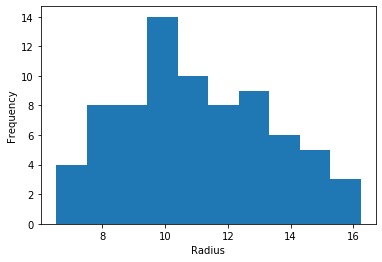

Density (No./mm2)    : 2506.5683788845877
Mean radius (um)     : 11.033233878616304
SD radius (um)       : 2.3084867970013287
Mean log radius (um) : 1.0331724835322091
SD log radius (x1000): 92.20507952223372


,area,radius,radius_log
0,270.083574,9.272016,0.967174
1,361.675699,10.729630,1.030585
2,827.191576,16.226622,1.210228
3,385.970899,11.084149,1.044702
4,432.789319,11.737168,1.069563
...,...,...,...
70,736.856894,15.314987,1.185117
71,700.668071,14.934175,1.174181
72,242.849765,8.792126,0.944094
73,206.671908,8.110839,0.909066


In [11]:
#sys.stdout = stdout_backup # print log for get_nearest_intersections()
areas = calculate_areas(nearest_intersections)
areas

In [12]:
areas.to_excel('../../Second_section_Jones_PAS/200126test/capillary_domain.xlsx')